In [32]:
import tensorflow as tf
from models import decoder, encoder, vae
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from scipy.stats import norm
from utils import data_loading
from constants import *

In [59]:
apes_info = pd.read_csv(APES_INFO_FILEPATH)
all_images_ids, train_ids, validation_ids, test_ids = data_loading.get_image_ids(apes_info, pathlib.Path(DATA_FILEPATH))

In [70]:
dataset = data_loading.load_full_dataset(DATA_FILEPATH, IMAGE_SIZE, all_images_ids)

train_dataset = data_loading.load_specific_dataset(dataset, train_ids, BATCH_SIZE)
validation_dataset = data_loading.load_specific_dataset(dataset, test_ids, BATCH_SIZE)

Found 10000 files belonging to 10000 classes.


In [10]:
decoder_model = decoder.build_decoder(LATENT_DIM)
encoder_model = encoder.build_encoder(LATENT_DIM)

vae_model = vae.VAE(encoder_model, decoder_model, RECONSTRUCTION_LOSS_WEIGHT, KL_LOSS_WEIGHT)
vae_model.compile(optimizer=tf.keras.optimizers.legacy.Adam())

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_reconstruction_loss", patience=5, restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_FILEPATH_VAE,
    save_weights_only=True,
    monitor="val_reconstruction_loss",
    mode="min",
    save_best_only=True,
)

csv_logger = tf.keras.callbacks.CSVLogger(HISTORY_FILEPATH_VAE, append=True)

In [12]:
history = vae_model.fit(
    train_dataset.repeat(STEPS_PER_EPOCH * EPOCHS_VAE),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS_VAE,
    batch_size=None,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint, csv_logger],
)

Epoch 1/200


2023-05-18 11:22:55.840058: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-18 11:22:55.840222: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - ETA: 0s - loss: 4294702.7269 - reconstruction_loss: 42935.0833 - kl_loss: 1194.3982

2023-05-18 11:24:19.163664: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-05-18 11:24:19.163785: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - 103s 2s/step - loss: 4291220.8091 - reconstruction_loss: 42900.4523 - kl_loss: 1175.5853 - val_loss: 4173155.2500 - val_reconstruction_loss: 41729.9062 - val_kl_loss: 164.7331
Epoch 2/200
54/54 [==============================] - 99s 2s/step - loss: 4124489.0273 - reconstruction_loss: 41241.5487 - kl_loss: 334.1454 - val_loss: 4099568.5000 - val_reconstruction_loss: 40989.9453 - val_kl_loss: 573.9377
Epoch 3/200
54/54 [==============================] - 98s 2s/step - loss: 4014088.7409 - reconstruction_loss: 40133.3001 - kl_loss: 758.7456 - val_loss: 3948956.2500 - val_reconstruction_loss: 39480.8516 - val_kl_loss: 870.9621
Epoch 4/200
54/54 [==============================] - 97s 2s/step - loss: 3773720.3455 - reconstruction_loss: 37722.6200 - kl_loss: 1458.3187 - val_loss: 3711521.2500 - val_reconstruction_loss: 37101.9609 - val_kl_loss: 1325.2405
Epoch 5/200
54/54 [==============================] - 95s 2s/step - loss: 3632334.7955 - reconstructi

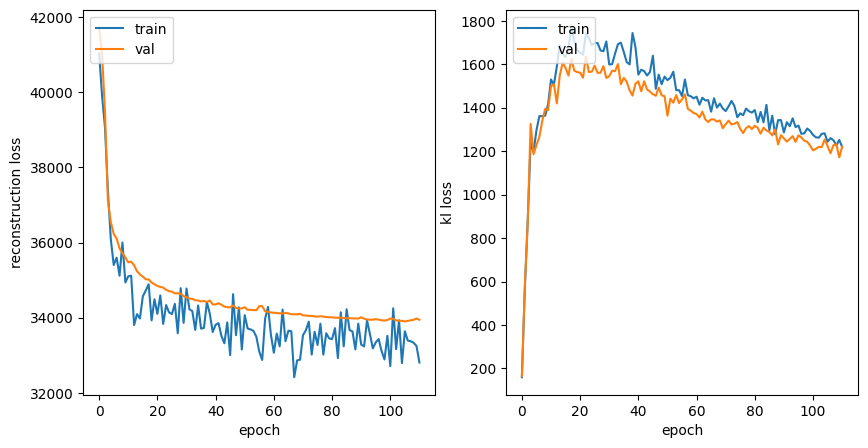

In [13]:
history_vae_training = pd.read_csv(HISTORY_FILEPATH_VAE)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history_vae_training["reconstruction_loss"])
plt.plot(history_vae_training["val_reconstruction_loss"])
plt.ylabel("reconstruction loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")

plt.subplot(122)
plt.plot(history_vae_training["kl_loss"])
plt.plot(history_vae_training["val_kl_loss"])
plt.ylabel("kl loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")

plt.show()

In [14]:
_, _, z = encoder_model.predict(validation_dataset)

12/12 [==============================] - 16s 339ms/step


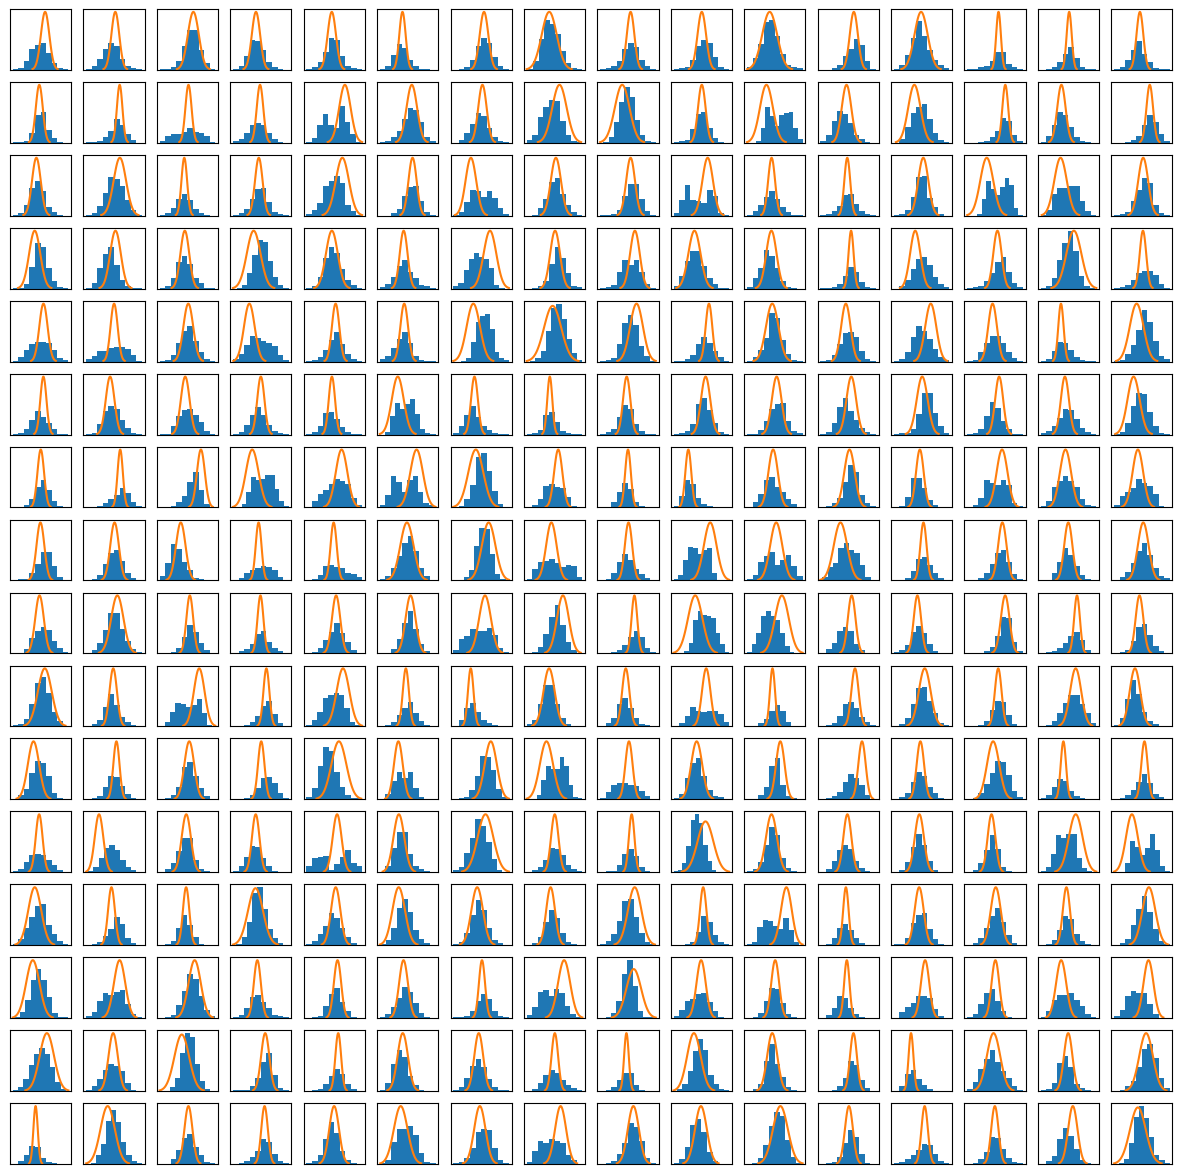

In [15]:
plot_size = int(np.sqrt(LATENT_DIM))

x_vector = np.linspace(-3, 3, 100)
norm_distribution = norm.pdf(x_vector, 0, 1)

plt.figure(figsize=(15, 15))


for i in range(LATENT_DIM):
    plt.subplot(plot_size, plot_size, i + 1)
    plt.hist(z[:, i], density=True)
    plt.plot(x_vector, norm_distribution)
    plt.xticks([])
    plt.yticks([])
plt.show()